# 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
from wordcloud import WordCloud

## Carga de datos

In [6]:
df = pd.read_csv('../data/train.csv')

In [7]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Limpieza de datos

Descargamos las _stopwords_ utilizadas para limpiar el texto.

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Removing urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Removing mentions and hashtags
    #   Mentions are removed because they are not important, 
    #   Only removing the '#' from hashtags because the text in the hashtag might be important
    text = re.sub(r'\@\w+|\#', '', text)

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing all numbers but 911 because it is an emergency number
    text = re.sub(r'\b(?!911\b)\d+\b', '', text)
    
    # If there are emojis, remove them
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

Aplicamos la función de preprocesamiento al texto.

In [10]:
df['text_clean'] = df['text'].apply(preprocess_text)

In [11]:
df[['text', 'text_clean']].head()

,text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


### Frecuencia de tweets de desastres y no desastres

In [12]:
disaster_tweets = df[df['target'] == 1]
non_disaster_tweets = df[df['target'] == 0]

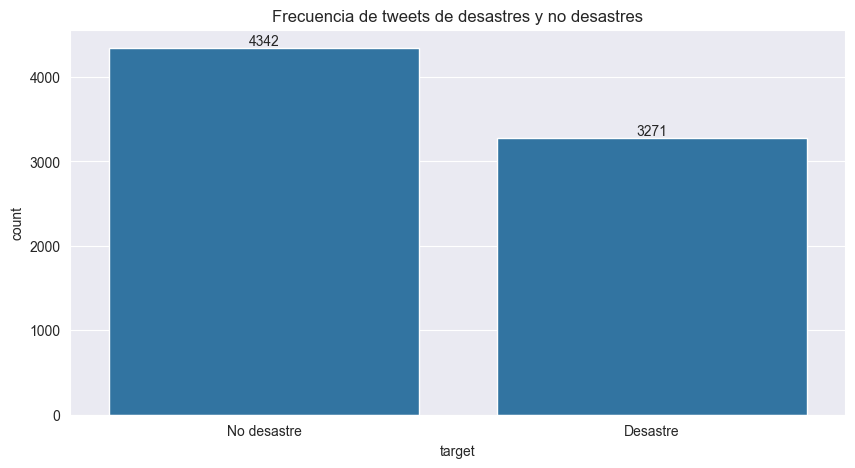

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='target')
plt.title('Frecuencia de tweets de desastres y no desastres')
plt.xticks([0, 1], ['No desastre', 'Desastre'])
for i, count in enumerate(df['target'].value_counts()):
    plt.text(i, count, count, ha='center', va='bottom')
plt.show()

**¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?**
Las palabras que podrían ser útiles para hacer un mejor modelo de clasificación son aquellas que se repiten con mayor frecuencia en los tweets de desastres y que no se repiten con tanta frecuencia en los tweets que no son de desastres y viceversa.

**¿Vale la pena explorar bigramas o trigramas para analizar contexto?**
Con base en lo que hemos analizado en la entrega del laboratorio anterior, el desempeño del modelo no mejoró al utilizar bigramas o trigramas (por lo menos, para este dataset. Por lo tanto, no vale la pena explorar bigramas o trigramas para analizar contexto.

### Frecuencia de palabras en tweets de desastres y no desastres

In [16]:
disaster_tweets_words = disaster_tweets['text_clean'].str.split(expand=True).stack()
non_disaster_tweets_words = non_disaster_tweets['text_clean'].str.split(expand=True).stack()

In [24]:
# Count words in disaster tweets and non-disaster tweets
disaster_tweets_word_counts = Counter(disaster_tweets_words)
non_disaster_tweets_word_counts = Counter(non_disaster_tweets_words)

# Find common words and their counts
common_words_counts = disaster_tweets_word_counts & non_disaster_tweets_word_counts

# Convert to a dictionary if needed
common_words_counts_dict = dict(common_words_counts)

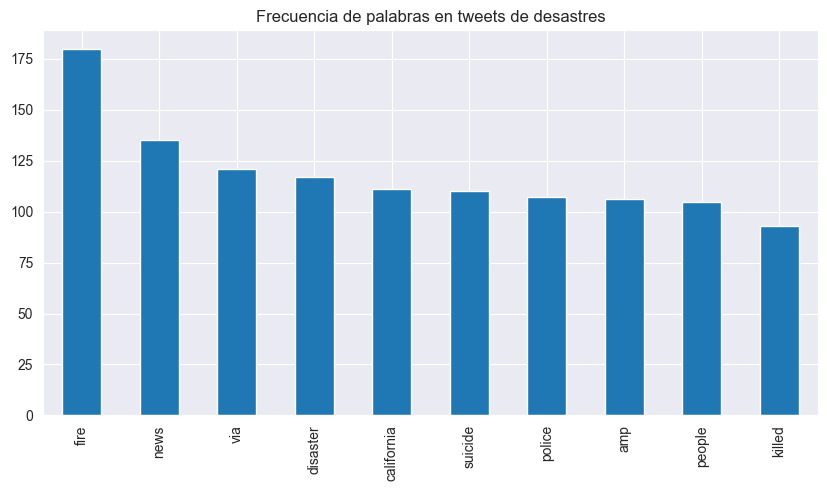

In [25]:
plt.figure(figsize=(10, 5))
disaster_tweets_words.value_counts().head(10).plot(kind='bar')
plt.title('Frecuencia de palabras en tweets de desastres')
plt.show()

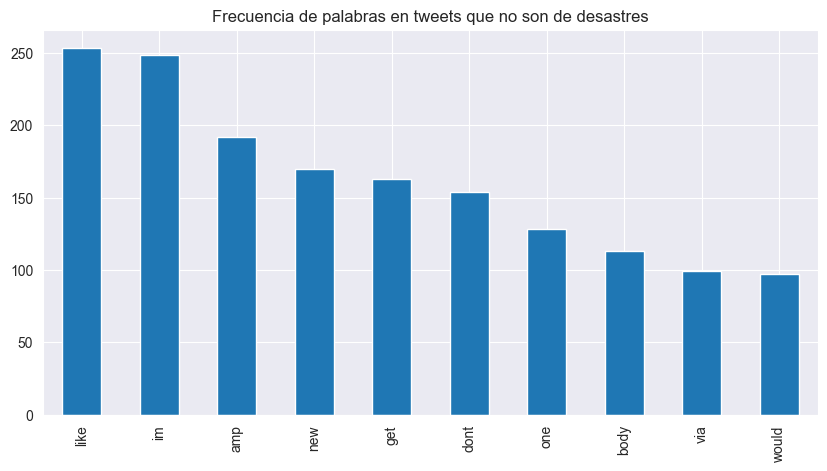

In [26]:
plt.figure(figsize=(10, 5))
non_disaster_tweets_words.value_counts().head(10).plot(kind='bar')
plt.title('Frecuencia de palabras en tweets que no son de desastres')
plt.show()

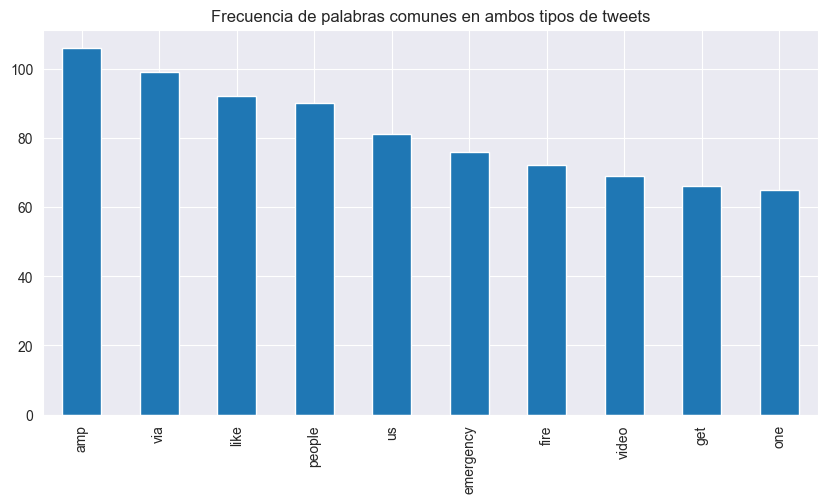

In [30]:
plt.figure(figsize=(10, 5))
pd.Series(common_words_counts_dict).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Frecuencia de palabras comunes en ambos tipos de tweets')
plt.show()

### Nube de palabras

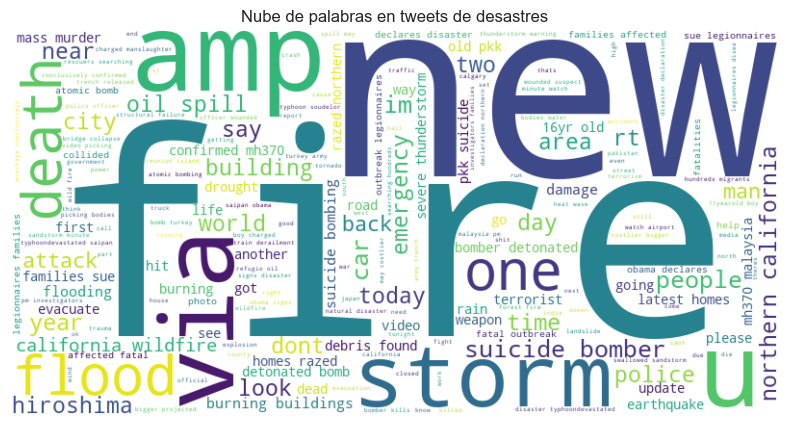

In [27]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_tweets_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras en tweets de desastres')
plt.show()

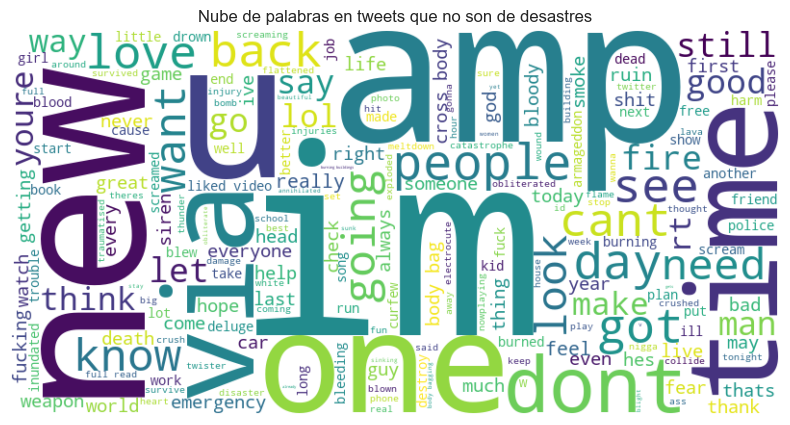

In [28]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_tweets_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras en tweets que no son de desastres')
plt.show()

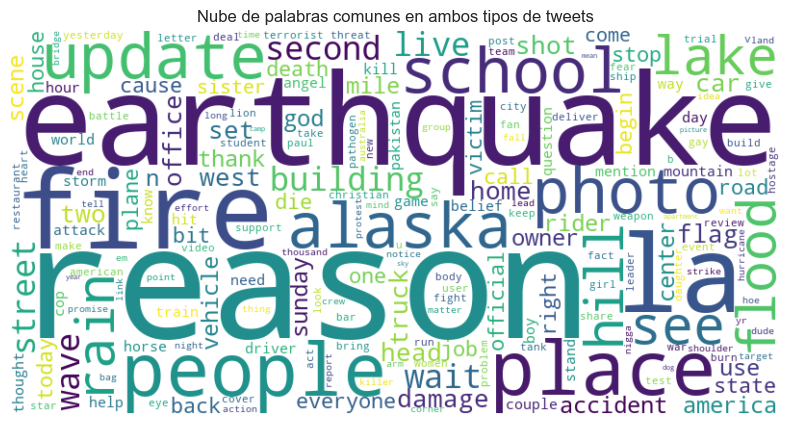

In [29]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(common_words_counts_dict))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras comunes en ambos tipos de tweets')
plt.show()

### Discusión sobre las palabras que tienen presencia en todas las categorías
Podemos observar que las palabras que se presentan en ambos tipos de tweet son palabras comunes que no necesariamente aportan información relevante para la clasificación de los tweets. Otras que, parecieran que si son relevantes (cómo fire, earthquake, etc.) tienden a utilizarse en ambos tipos de tweets pero con diferente connotación y son muy dependientes del contexto.

## Clasificación de palabras
Para poder realizar la clasificación de palabras se utilizó el lexicon VADER (Valence Aware Dictionary and sEntiment Reasoner) que es un lexicon y herramienta de análisis de sentimientos que es específico para sentimientos sociales. VADER no solo informa si el sentimiento es positivo o negativo, sino que también informa sobre la intensidad del sentimiento (o, como se refiere en el paper, "valence"). VADER ha sido utilizado en muchos estudios y ha demostrado ser un lexicon muy útil y eficaz para el análisis de sentimientos en redes sociales, en particular. Para más información sobre VADER, se puede consultar el [paper original](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)

Lo relevante para nuestro desarrollo se puede leer en su [README](https://github.com/cjhutto/vaderSentiment/tree/master?tab=readme-ov-file#resources-and-dataset-descriptions) y se hace referencia, particularmente, al archivo [vader_lexicon.txt](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt).

Para poder utilizar la implementación de VADER en Python, se puede utilizar la librería `nltk` que ya tiene implementado el lexicon de VADER.